<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/05_Evaluar_ruido_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Evaluar Robustez evaluando con ruido


In [ ]:
# IMPORTS Y CONFIGURACIÓN BÁSICA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
import timm  # para el modelo ViT
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from google.colab import drive

drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Proyecto_PTI")
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

from prepare_dataset import load_clean_split_kaggle, BrainTumorDataset

# Elegimos dispositivo (GPU si hay, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Dispositivo: cuda


In [ ]:
# CARGAR SPLITS LIMPIOS (TRAIN / VAL / TEST)

# Ruta al dataset en Kaggle (ajústala si usas otra ubicación)
BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"

# Cargamos las rutas de imágenes y etiquetas de cada split,
# y la lista de nombres de clases.
(X_train, y_train), (X_val, y_val), (X_test, y_test), classes = load_clean_split_kaggle(BASE_DIR)

print("Clases:", classes)
print("Número de clases:", len(classes))

# Creamos el mapeo de nombre de clase -> índice numérico
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print("class_to_idx:", class_to_idx)



Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']
Número de clases: 4
class_to_idx: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# MÓDULOS DE RUIDO GAUSSIANO

class AddGaussianNoise(nn.Module):
    """
    Módulo que añade ruido gaussiano con media fija y desviación estándar fija.
    - Se asume que la imagen ya está en escala [0,1] (después de ToTensor)
      antes de normalizar.
    """
    def __init__(self, mean=0.0, std=0.05):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        # Genera ruido con la misma forma que el tensor de entrada
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"


class RandomGaussianNoiseRange(nn.Module):
    """
    Módulo para entrenamiento con ruido:
    - Con probabilidad p, aplica ruido gaussiano.
    - La desviación estándar del ruido se toma aleatoriamente
      entre std_min y std_max.
    """
    def __init__(self, p=0.5, std_min=0.0, std_max=0.07):
        super().__init__()
        self.p = p
        self.std_min = std_min
        self.std_max = std_max

    def forward(self, tensor):
        # Sorteamos si aplicamos ruido o no
        if torch.rand(1).item() < self.p:
            # Elegimos una std aleatoria en [std_min, std_max]
            std = torch.empty(1).uniform_(self.std_min, self.std_max).item()
            noise = torch.randn_like(tensor) * std
            return tensor + noise
        # Sin ruido, regresamos el tensor original
        return tensor

    def __repr__(self):
        return (f"{self.__class__.__name__}(p={self.p}, "
                f"std_min={self.std_min}, std_max={self.std_max})")

In [ ]:
# TRANSFORM PARA TEST CON RUIDO Y DATASET NOISY

def make_noisy_test_loader(noise_std, batch_size=32):
    """
    Crea un DataLoader del conjunto de TEST donde las imágenes
    llevan ruido gaussiano con desviación estándar noise_std.

    Este loader SÓLO se usa para evaluar robustez frente a ruido.
    """

    # 1) Definimos el pipeline de transformaciones:
    #    - Redimensionar a 224x224
    #    - Convertir a tensor [0,1]
    #    - Añadir ruido gaussiano con std = noise_std
    #    - Normalizar con las medias/std de ImageNet
    test_transform_noisy = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        AddGaussianNoise(mean=0.0, std=noise_std),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # 2) Creamos el Dataset usando las rutas del split de test
    test_set_noisy = BrainTumorDataset(
        X_test,
        y_test,
        transform=test_transform_noisy,
        class_to_idx=class_to_idx
    )

    # 3) DataLoader para iterar por batches
    test_loader_noisy = DataLoader(
        test_set_noisy,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return test_loader_noisy



In [ ]:
# FUNCIÓN DE EVALUACIÓN (UNA PASADA POR TEST)

criterion = nn.CrossEntropyLoss()

def eval_one_epoch(model, dataloader, criterion):
    """
    Recorre todo el DataLoader (de test) sin acumular gradientes y calcula:
    - pérdida promedio (loss)
    - exactitud (accuracy)
    """
    model.eval()  # modo evaluación
    running_loss = 0.0
    correct = 0
    total = 0

    # Desactivamos gradientes para ahorrar memoria y tiempo
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Acumulamos la pérdida total ponderada por el tamaño del batch
            running_loss += loss.item() * images.size(0)

            # Predicción de clase (índice del logit máximo)
            _, preds = torch.max(outputs, 1)

            # Contamos aciertos
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



In [ ]:
# CONSTRUCTORES DE MODELOS (ResNet-50, ResNet-101, ViT)

def create_resnet50(num_classes):
    """
    Crea una ResNet-50 y reemplaza la última capa fully-connected
    por una capa con num_classes salidas.

    NOTA: usamos weights=None porque después cargamos tus pesos entrenados
    desde un archivo .pth (no necesitamos descargar ImageNet aquí).
    """
    model = models.resnet50(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, num_classes)
    )
    return model


def create_resnet101(num_classes):
    """
    Igual que create_resnet50, pero para ResNet-101.
    """
    model = models.resnet101(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, num_classes)
    )
    return model


def create_vit_base(num_classes):
    """
    Crea un ViT Base (patch16-224) usando timm y ajusta la cabeza
    al número de clases del dataset.
    """
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=False,
        num_classes=num_classes  # ajusta la cabeza de clasificación
    )
    return model

In [ ]:
# EVALUACIÓN DE ROBUSTEZ CON RUIDO

def evaluate_model_with_noise(create_fn, ckpt_path, noise_levels, batch_size=32, model_name="modelo"):
    """
    Evalúa un modelo (ResNet-50, ResNet-101 o ViT) cargado desde ckpt_path
    para distintos niveles de ruido gaussiano en las imágenes de TEST.

    Parámetros:
    - create_fn: función que construye la arquitectura del modelo
                 (create_resnet50, create_resnet101 o create_vit_base).
    - ckpt_path: ruta al archivo .pth con los pesos entrenados.
    - noise_levels: lista de std de ruido, por ejemplo [0.0, 0.02, 0.05, 0.10, 0.20].
    - batch_size: tamaño de batch para evaluación.
    - model_name: nombre descriptivo para imprimir en consola.
    """
    print(f"\n=== Evaluando {model_name} desde: {ckpt_path} ===")

    # 1) Creamos el modelo y cargamos los pesos guardados
    model = create_fn(len(classes)).to(device)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    results = []

    # 2) Para cada nivel de ruido, creamos un DataLoader de test con ese ruido
    for std in noise_levels:
        print(f"\n[{model_name}] std ruido = {std}")
        test_loader_noisy = make_noisy_test_loader(noise_std=std, batch_size=batch_size)

        # 3) Evaluamos el modelo sobre este conjunto ruidoso
        test_loss, test_acc = eval_one_epoch(model, test_loader_noisy, criterion)
        print(f"  Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        results.append((std, test_loss, test_acc))

    return results

# LLAMAR A LA EVALUACIÓN PARA CADA MODELO Y VARIANTE

# Ruta base donde se guardaron los pesos .pth en tu Drive
base_path = "/content/drive/MyDrive/Proyecto_PTI"

# Niveles de ruido que quieres probar
noise_levels = [0.0, 0.02, 0.05, 0.10, 0.20]

# ResNet-50
resnet50_aug_results = evaluate_model_with_noise(
    create_resnet50,
    f"{base_path}/resnet50_aug_best.pth",
    noise_levels,
    model_name="ResNet-50 (con Aug)"
)

resnet50_noaug_results = evaluate_model_with_noise(
    create_resnet50,
    f"{base_path}/resnet50_noaug_best.pth",
    noise_levels,
    model_name="ResNet-50 (sin Aug)"
)

# ResNet-101
resnet101_aug_results = evaluate_model_with_noise(
    create_resnet101,
    f"{base_path}/resnet101_aug_best.pth",
    noise_levels,
    model_name="ResNet-101 (con Aug)"
)

resnet101_noaug_results = evaluate_model_with_noise(
    create_resnet101,
    f"{base_path}/resnet101_noaug_best.pth",
    noise_levels,
    model_name="ResNet-101 (sin Aug)"
)

# ViT
vit_aug_results = evaluate_model_with_noise(
    create_vit_base,
    f"{base_path}/vit_aug_best.pth",
    noise_levels,
    model_name="ViT (con Aug)"
)

vit_noaug_results = evaluate_model_with_noise(
    create_vit_base,
    f"{base_path}/vit_noaug_best.pth",
    noise_levels,
    model_name="ViT (sin Aug)"
)


=== Evaluando ResNet-50 (con Aug) desde: /content/drive/MyDrive/Proyecto_PTI/resnet50_aug_best.pth ===

[ResNet-50 (con Aug)] std ruido = 0.0
  Test Loss: 0.0414 | Test Acc: 0.9802

[ResNet-50 (con Aug)] std ruido = 0.02
  Test Loss: 0.7785 | Test Acc: 0.7007

[ResNet-50 (con Aug)] std ruido = 0.05
  Test Loss: 1.9496 | Test Acc: 0.2973

[ResNet-50 (con Aug)] std ruido = 0.1
  Test Loss: 10.0640 | Test Acc: 0.2567

[ResNet-50 (con Aug)] std ruido = 0.2
  Test Loss: 62.3545 | Test Acc: 0.2567

=== Evaluando ResNet-50 (sin Aug) desde: /content/drive/MyDrive/Proyecto_PTI/resnet50_noaug_best.pth ===

[ResNet-50 (sin Aug)] std ruido = 0.0
  Test Loss: 0.0316 | Test Acc: 0.9881

[ResNet-50 (sin Aug)] std ruido = 0.02
  Test Loss: 0.9469 | Test Acc: 0.6521

[ResNet-50 (sin Aug)] std ruido = 0.05
  Test Loss: 5.3397 | Test Acc: 0.2666

[ResNet-50 (sin Aug)] std ruido = 0.1
  Test Loss: 38.4488 | Test Acc: 0.2567

[ResNet-50 (sin Aug)] std ruido = 0.2
  Test Loss: 211.4261 | Test Acc: 0.2567



In [ ]:
import pandas as pd

# Lista de niveles de ruido usados
noise_levels = [0.0, 0.02, 0.05, 0.10, 0.20]

# Función auxiliar para convertir resultados [(std, loss, acc), ...] -> {std: acc}
def results_to_acc_dict(results):
    return {std: acc for (std, loss, acc) in results}

# Lista con nombre del modelo, flag "Sí/No" y resultados
rows_info = [
    ("ResNet-50",  "Sí", resnet50_aug_results),
    ("ResNet-50",  "No", resnet50_noaug_results),
    ("ResNet-101", "Sí", resnet101_aug_results),
    ("ResNet-101", "No", resnet101_noaug_results),
    ("ViT-B/16",   "Sí", vit_aug_results),
    ("ViT-B/16",   "No", vit_noaug_results),
]

# Construimos filas para el DataFrame
rows = []
for model_name, aug_flag, results in rows_info:
    acc_dict = results_to_acc_dict(results)
    row = {
        "Modelo": model_name,
        "Aug": aug_flag
    }
    # Agregamos accuracies para cada nivel de ruido
    for std in noise_levels:
        row[str(std)] = round(acc_dict.get(std, float('nan')), 4)
    rows.append(row)

# Crear DataFrame
df_resultados = pd.DataFrame(rows)

# Mostrar tabla
df_resultados


,Modelo,Aug,0.0,0.02,0.05,0.1,0.2
0,ResNet-50,Sí,0.9802,0.7007,0.2973,0.2567,0.2567
1,ResNet-50,No,0.9881,0.6521,0.2666,0.2567,0.2567
2,ResNet-101,Sí,0.9891,0.9623,0.4014,0.2755,0.2953
3,ResNet-101,No,0.9871,0.8702,0.2854,0.2577,0.2567
4,ViT-B/16,Sí,0.9941,0.9931,0.9851,0.9613,0.7413
5,ViT-B/16,No,0.9901,0.9851,0.9792,0.9604,0.8107


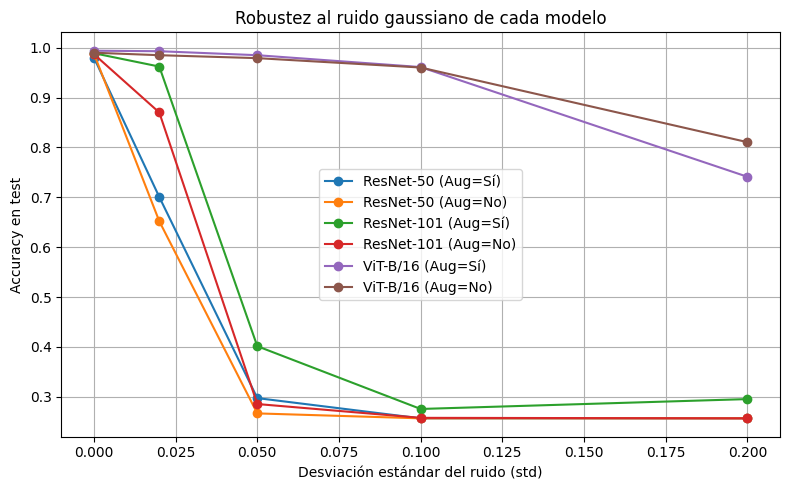

In [ ]:
import matplotlib.pyplot as plt

noise_levels = [0.0, 0.02, 0.05, 0.10, 0.20]
noise_cols = [str(n) for n in noise_levels]

plt.figure(figsize=(8, 5))

for idx, row in df_resultados.iterrows():
    accs = [row[col] for col in noise_cols]
    label = f"{row['Modelo']} (Aug={row['Aug']})"
    plt.plot(noise_levels, accs, marker='o', label=label)

plt.xlabel("Desviación estándar del ruido (std)")
plt.ylabel("Accuracy en test")
plt.title("Robustez al ruido gaussiano de cada modelo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Definimos niveles de ruido (0.0 = sin ruido)

noise_levels = [0.0, 0.02, 0.05, 0.10, 0.20]

base_path = "/content/drive/MyDrive/Proyecto_PTI"


# Evaluar ResNet-50 entrenada con ruido (con y sin Aug)

# Entrenada con ruido + augmentation
resnet50_noise_aug_results = evaluate_model_with_noise(
    create_resnet50,
    f"{base_path}/resnet50_noise_aug_best.pth",
    noise_levels,
    model_name="ResNet-50 Noise (con Aug)"
)

# Entrenada con ruido, sin augmentation
resnet50_noise_noaug_results = evaluate_model_with_noise(
    create_resnet50,
    f"{base_path}/resnet50_noise_noaug_best.pth",
    noise_levels,
    model_name="ResNet-50 Noise (sin Aug)"
)



=== Evaluando ResNet-50 Noise (con Aug) desde: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_aug_best.pth ===

[ResNet-50 Noise (con Aug)] std ruido = 0.0
  Test Loss: 0.0155 | Test Acc: 0.9931

[ResNet-50 Noise (con Aug)] std ruido = 0.02
  Test Loss: 0.0145 | Test Acc: 0.9950

[ResNet-50 Noise (con Aug)] std ruido = 0.05
  Test Loss: 0.0323 | Test Acc: 0.9861

[ResNet-50 Noise (con Aug)] std ruido = 0.1
  Test Loss: 0.0474 | Test Acc: 0.9822

[ResNet-50 Noise (con Aug)] std ruido = 0.2
  Test Loss: 27.8076 | Test Acc: 0.2725

=== Evaluando ResNet-50 Noise (sin Aug) desde: /content/drive/MyDrive/Proyecto_PTI/resnet50_noise_noaug_best.pth ===

[ResNet-50 Noise (sin Aug)] std ruido = 0.0
  Test Loss: 0.0315 | Test Acc: 0.9881

[ResNet-50 Noise (sin Aug)] std ruido = 0.02
  Test Loss: 0.0390 | Test Acc: 0.9841

[ResNet-50 Noise (sin Aug)] std ruido = 0.05
  Test Loss: 0.0588 | Test Acc: 0.9812

[ResNet-50 Noise (sin Aug)] std ruido = 0.1
  Test Loss: 0.1095 | Test Acc: 0.9633

[Res

In [ ]:
rows_info = [
    ("ResNet-50",            "Sí", resnet50_aug_results),
    ("ResNet-50",            "No", resnet50_noaug_results),
    ("ResNet-101",           "Sí", resnet101_aug_results),
    ("ResNet-101",           "No", resnet101_noaug_results),
    ("ViT-B/16",             "Sí", vit_aug_results),
    ("ViT-B/16",             "No", vit_noaug_results),
    ("ResNet-50 NoiseTrain", "Sí", resnet50_noise_aug_results),
    ("ResNet-50 NoiseTrain", "No", resnet50_noise_noaug_results),
]


In [ ]:
import pandas as pd

noise_levels = [0.0, 0.02, 0.05, 0.10, 0.20]
noise_cols = [str(n) for n in noise_levels]

def results_to_acc_dict(results):
    return {std: acc for (std, loss, acc) in results}

rows = []
for model_name, aug_flag, results in rows_info:
    acc_dict = results_to_acc_dict(results)
    row = {
        "Modelo": model_name,
        "Aug": aug_flag
    }
    for std in noise_levels:
        row[str(std)] = round(acc_dict.get(std, float('nan')), 4)
    rows.append(row)

df_resultados = pd.DataFrame(rows)
df_resultados


,Modelo,Aug,0.0,0.02,0.05,0.1,0.2
0,ResNet-50,Sí,0.9802,0.7007,0.2973,0.2567,0.2567
1,ResNet-50,No,0.9881,0.6521,0.2666,0.2567,0.2567
2,ResNet-101,Sí,0.9891,0.9623,0.4014,0.2755,0.2953
3,ResNet-101,No,0.9871,0.8702,0.2854,0.2577,0.2567
4,ViT-B/16,Sí,0.9941,0.9931,0.9851,0.9613,0.7413
5,ViT-B/16,No,0.9901,0.9851,0.9792,0.9604,0.8107
6,ResNet-50 NoiseTrain,Sí,0.9931,0.9950,0.9861,0.9822,0.2725
7,ResNet-50 NoiseTrain,No,0.9881,0.9841,0.9812,0.9633,0.3726


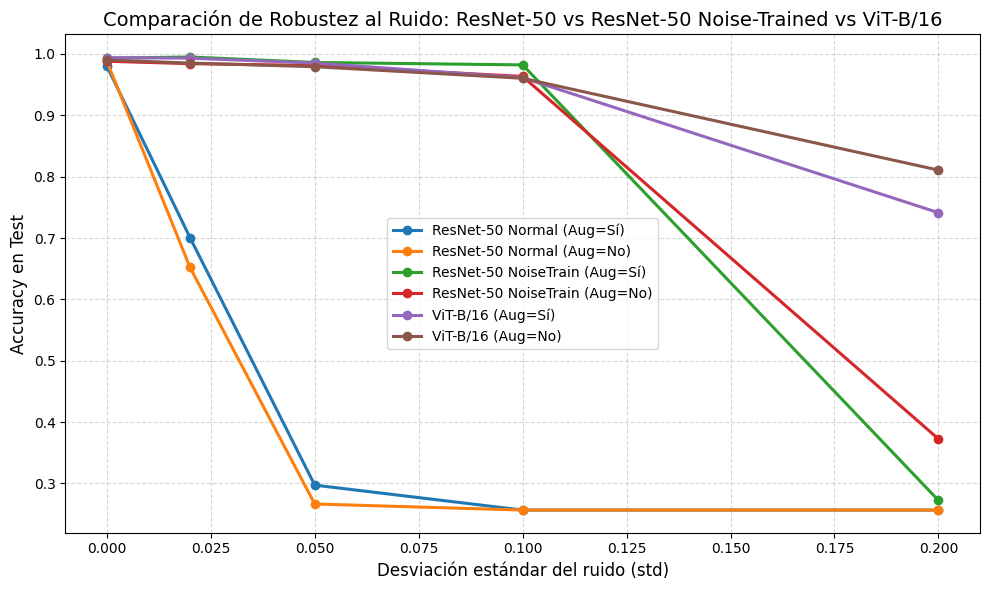

In [ ]:
import matplotlib.pyplot as plt

def results_to_acc_list(results, noise_levels):
    """
    Convierte una lista de (std, loss, acc) en una lista de accuracies
    estrictamente en el orden de noise_levels.
    """
    std_to_acc = {std: acc for (std, loss, acc) in results}
    return [std_to_acc[std] for std in noise_levels]


plt.figure(figsize=(10, 6))

series = [
    ("ResNet-50 Normal (Aug=Sí)",       resnet50_aug_results),
    ("ResNet-50 Normal (Aug=No)",       resnet50_noaug_results),
    ("ResNet-50 NoiseTrain (Aug=Sí)",   resnet50_noise_aug_results),
    ("ResNet-50 NoiseTrain (Aug=No)",   resnet50_noise_noaug_results),
    ("ViT-B/16 (Aug=Sí)",               vit_aug_results),
    ("ViT-B/16 (Aug=No)",               vit_noaug_results),
]

for label, results in series:
    accs = results_to_acc_list(results, noise_levels)
    plt.plot(noise_levels, accs, marker='o', linewidth=2.2, label=label)

plt.xlabel("Desviación estándar del ruido (std)", fontsize=12)
plt.ylabel("Accuracy en Test", fontsize=12)
plt.title("Comparación de Robustez al Ruido: ResNet-50 vs ResNet-50 Noise-Trained vs ViT-B/16", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:

!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=bbcdc0d2303fadbee8ebeef623899ce729ff752d216b3297692ff3fe5368ada5
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), classes = load_clean_split_kaggle(BASE_DIR)


Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009



In [ ]:

num_classes = len(classes)
# 2.1 ResNet-50 baseline (sin ruido en entrenamiento)
resnet50_base = create_resnet50(num_classes).to(device)
state_dict = torch.load(f"{base_path}/resnet50_aug_best.pth", map_location=device)
resnet50_base.load_state_dict(state_dict)
resnet50_base.eval()


# 2.2 ResNet-50 entrenada con ruido (usa los pesos nuevos)
resnet50_noise = create_resnet50(num_classes).to(device)
state_dict = torch.load(f"{base_path}/resnet50_noise_aug_best.pth", map_location=device)
resnet50_noise.load_state_dict(state_dict)
resnet50_noise.eval()

# 2.3 ViT-B/16 (modelo más robusto)
vit_model = create_vit_base(num_classes).to(device)
state_dict = torch.load(f"{base_path}/vit_aug_best.pth", map_location=device)
vit_model.load_state_dict(state_dict)
vit_model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
# Usamos tu AddGaussianNoise ya definido
# class AddGaussianNoise(nn.Module): ...

def get_transform_with_noise(noise_std):
    """
    Devuelve un transform que:
    - Resize a 224x224
    - ToTensor
    - Añade ruido gaussiano con std = noise_std
    - Normaliza como ImageNet
    """
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        AddGaussianNoise(mean=0.0, std=noise_std),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])


In [ ]:
def vit_reshape_transform(tensor):
    """
    tensor: salida de la capa target en ViT, típicamente de forma [B, N, C]
    donde:
        B = batch size
        N = número de tokens (1 CLS + P parches)
        C = número de canales

    Esta función:
    - Quita el token CLS (posición 0)
    - Reorganiza los tokens restantes en una cuadrícula (h, w)
    - Devuelve un tensor de forma [B, C, h, w], como si fuera un feature map conv.
    """
    # tensor: [B, N, C]
    B, N, C = tensor.shape

    # Quitamos el token CLS (posición 0) → [B, N-1, C]
    tensor = tensor[:, 1:, :]

    # Asumimos parches en cuadrícula cuadrada: (N-1) = h*w
    h = w = int((N - 1) ** 0.5)

    # [B, (h*w), C] → [B, h, w, C] → [B, C, h, w]
    tensor = tensor.reshape(B, h, w, C).permute(0, 3, 1, 2)
    return tensor


In [ ]:
# GradCAM para ResNet-50 base

target_layers_resnet_base = [resnet50_base.layer4[-1]]
cam_resnet_base = GradCAM(
    model=resnet50_base,
    target_layers=target_layers_resnet_base
)


# GradCAM para ResNet-50 noise-train
target_layers_resnet_noise = [resnet50_noise.layer4[-1]]
cam_resnet_noise = GradCAM(
    model=resnet50_noise,
    target_layers=target_layers_resnet_noise
)


# GradCAM para ViT
target_layers_vit = [vit_model.blocks[-1].norm1]
cam_vit = GradCAM(
    model=vit_model,
    target_layers=target_layers_vit,
    reshape_transform=vit_reshape_transform
)



In [ ]:
def gradcam_on_image(cam, img_path, noise_std, title_prefix=""):
    pil_img = Image.open(img_path).convert("RGB")


    transform = get_transform_with_noise(noise_std)
    input_tensor = transform(pil_img).unsqueeze(0).to(device)


    rgb_img = np.array(pil_img.resize((224, 224)), dtype=np.float32) / 255.0


    grayscale_cam = cam(input_tensor=input_tensor)[0]  # [H, W]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(4, 4))
    plt.imshow(visualization)
    plt.title(f"{title_prefix} | std={noise_std}")
    plt.axis("off")
    plt.show()


In [ ]:
def visualize_three_noises_for_idx(model_name, cam, idx):
    """
    Aplica GradCAM a la imagen X_test[idx] con:
    - std = 0.0 (limpia)
    - std = 0.05 (ruido medio)
    - std = 0.2 (ruido fuerte)
    """
    img_path = X_test[idx]
    print(f"Imagen de test idx={idx}: {img_path}\n")

    noise_cases = [
        (0.0,  "limpia"),
        (0.05, "ruido medio"),
        (0.2,  "ruido fuerte"),
    ]

    for std, desc in noise_cases:
        gradcam_on_image(
            cam=cam,
            img_path=img_path,
            noise_std=std,
            title_prefix=f"{model_name} ({desc})"
        )


Imagen de test idx=0: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1013.jpg



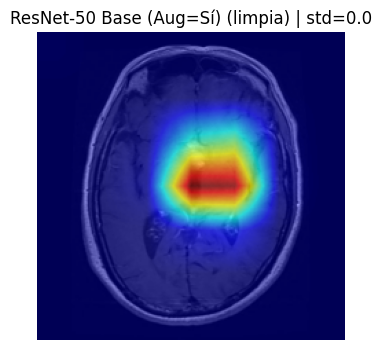

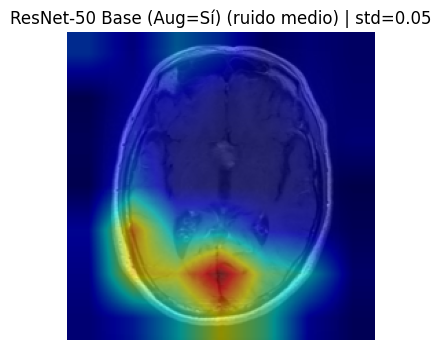

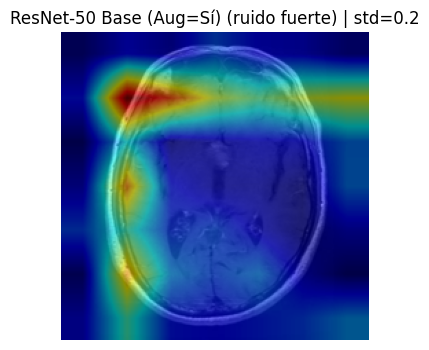

Imagen de test idx=0: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1013.jpg



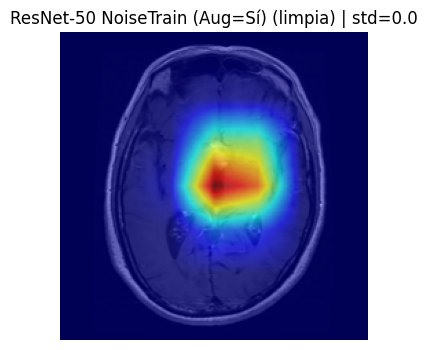

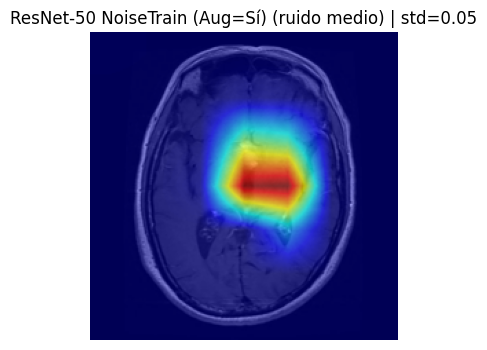

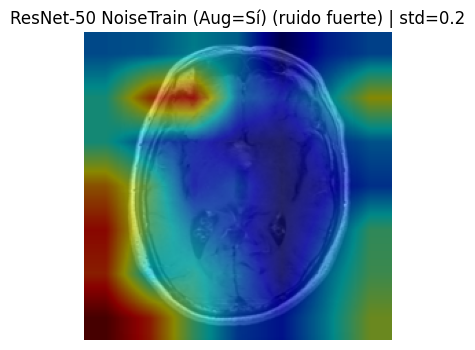

Imagen de test idx=0: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1013.jpg



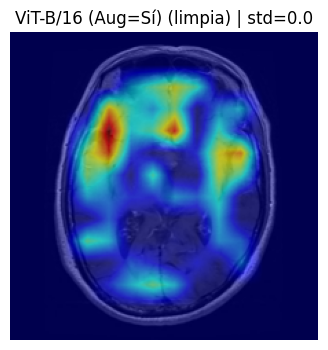

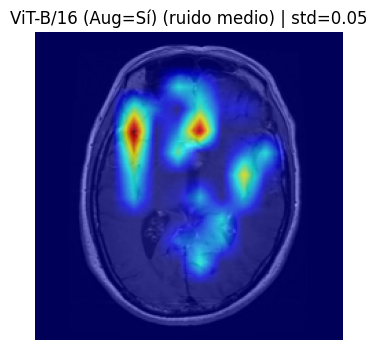

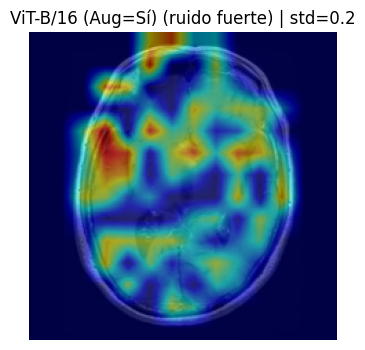

In [ ]:
idx = 0

# ResNet-50 baseline
visualize_three_noises_for_idx(
    model_name="ResNet-50 Base (Aug=Sí)",
    cam=cam_resnet_base,
    idx=idx
)

# ResNet-50 entrenada con ruido
visualize_three_noises_for_idx(
    model_name="ResNet-50 NoiseTrain (Aug=Sí)",
    cam=cam_resnet_noise,
    idx=idx
)

# ViT-B/16
visualize_three_noises_for_idx(
    model_name="ViT-B/16 (Aug=Sí)",
    cam=cam_vit,
    idx=idx
)
